# What is the Coronavirus Death Rate with Hyperparameter Tuning
 Examine the death rate and time to death/recovery distribution with Python

In this post, we dive into the coronavirus data using a machine learning algorithm: hyperparameter tuning.

You’ll see the step-by-step procedures of how to find the parameters of a model that is best fitting the COVID-19 data.

The goal is to estimate:

- the death rate, aka case fatality ratio (CFR) and
- the distribution of time from symptoms to death/recovery.
If you want:

- more insights about coronavirus
- or to see an example of hyperparameter tuning/optimization in Python

take a look!

Let’s roll.

Table Of Contents
- Step #1: Exploring the Data: COVID-19
- Step #2: Cleaning the Data
- Step #3: Explaining the Methodologies
- Step #4: Smoothing the Data
- Step #5: Choosing the Optimal Model
- Step #6: Running Simulations for Hyperparameter Tuning
- Step #7: Visualizing the Results

The dataset we are using is COVID-19 Complete Dataset from Kaggle. It includes the number of confirmed, death, and recovered cases daily across the globe.

Yes, we know the numbers are not accurate due to various reasons. But let’s leave that concern out for this project.

And to simplify the analysis, we zoom into China’s Hubei province, the first heavily affected region.

# Exploring the Data: COVID-19

In [45]:
# import packages
import pandas as pd
import numpy as np
import os
from datetime import timedelta, datetime

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

from sklearn.metrics import mean_squared_error
pd.options.mode.chained_assignment = None


# read the data
df = pd.read_csv('D:\\data\\covid_19_clean_complete.csv')
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,1/22/20,2.0,0.0,0.0
1,NaN,Japan,36.0000,138.0000,1/22/20,2.0,0.0,0.0
2,NaN,Singapore,1.2833,103.8333,1/22/20,0.0,0.0,0.0
3,NaN,Nepal,28.1667,84.2500,1/22/20,0.0,0.0,0.0
4,NaN,Malaysia,2.5000,112.5000,1/22/20,0.0,0.0,0.0


In [46]:
# examining the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19220 entries, 0 to 19219
Data columns (total 8 columns):
Province/State    8432 non-null object
Country/Region    19220 non-null object
Lat               19220 non-null float64
Long              19220 non-null float64
Date              19220 non-null object
Confirmed         19219 non-null float64
Deaths            19219 non-null float64
Recovered         19219 non-null float64
dtypes: float64(5), object(3)
memory usage: 1.2+ MB


The dataset has 19,220 rows and 8 features. The rows represent daily data for different provinces/states from different countries/regions. While the features are:

- Province/State: the province/state of the location

- Country/Region: the country/region of the location

- Lat: latitude of the location

- Long: longitude of the location

- Date: date of the cumulative report

- Confirmed: cumulative number of confirmed cases till this day

- Deaths: cumulative number of deaths till this day

- Recovered: cumulative number of recovered cases till this day

We also notice that the feature Date needs to be converted to DateTime format.

# Cleaning the Data

In this step, we clean the data up to fit our project by:

- converting the Date feature to the correct format.
- narrowing down the data to Hubei.
- turning the cumulative counts to single-day counts: New_Confirmed, New_Deaths, New_Recovered.

In [20]:
# convert datetime.
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')


# only include Hubei data
df = df[df['Province/State'] == 'Hubei'].reset_index(drop=True)

# The dataset gives cummulative counts of Confirmed, Deaths and Recovered. 
# We want to analyze new cases, so we apply the difference operator of pandas.
df['New_Confirmed'] = df['Confirmed'].diff()
df['New_Deaths'] = df['Deaths'].diff()
df['New_Recovered'] = df['Recovered'].diff()

# Explaining the Methodologies

As claimed at the beginning of the post, we are trying to estimate the death rate and the distribution of time from symptoms to death/recovery.

You might wonder, why do we want to estimate the death rate?

Isn’t it simply (2,803/67,103) = 4.2% on March 2nd, 2020, for Hubei, based on the data below?


It is not the best way because of two main reasons:

1- This death rate is likely biased upwards.
Early in the epidemic outbreak, the confirmed cases only include people being officially diagnosed with severe symptoms. Others with minor symptoms or not diagnosed are not counted in the denominator.

2- This death rate is also likely biased downwards.
There is a time gap between being infected and dying/recovering. So we can’t immediately observe the outcome (whether they live) for people infected.

This could be a big impact when the epidemic is growing exponentially.
For example, assume on day T = 1 there is 1 new case; T = 2 there are 2 new cases; T = 3 has 100 new cases.

The person infected on day T = 1 died on T = 3. The simple death rate at T = 3 would be 1 / (1 + 2 + 100), which is not accurate.
At that time point, we only know for sure the death rate of T = 1 is 1/1 = 100%.

While we can’t address the first problem without extra data, we’ll be accomodating for the second problem.

As for the time from symptoms to death/recovery, most articles provide summary information such as average time to death/recovery. We want to estimate the distribution to get a full picture.

To do these, we use hyperparameter optimization techniques from machine learning.

Hyperparameter optimization or tuning finds a tuple of hyperparameters that yields an optimal model which minimizes a predefined loss function on given independent data.

Wikipedia
As you can tell, the key is to find an optimal model first.

In the next step, we will smooth the data and find a target model that we’ll be tuning its parameters to fit our data.

# Smoothing the Data

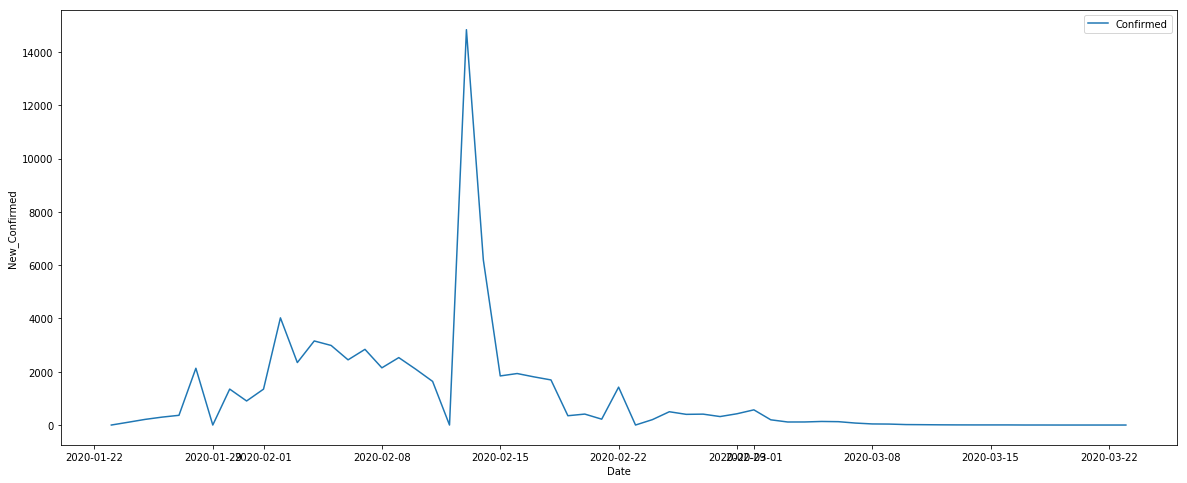

In [21]:
import seaborn as sns

# Look at the data a little bit.

plt.figure(figsize = (20, 8))
sns.lineplot(x="Date", y="New_Confirmed", data=df, label='Confirmed')

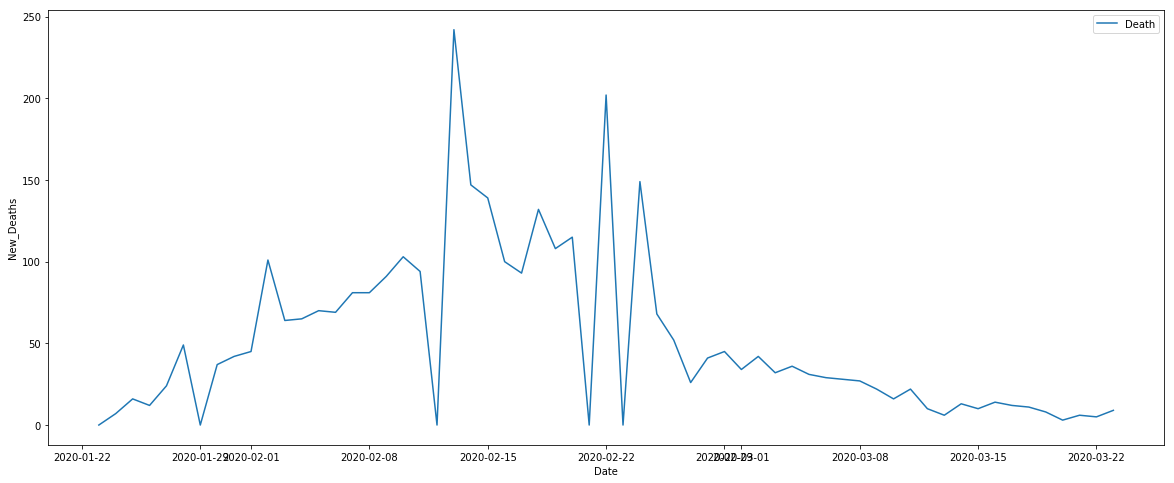

In [22]:
plt.figure(figsize = (20, 8))
sns.lineplot(x="Date", y="New_Deaths", data=df, label='Death')

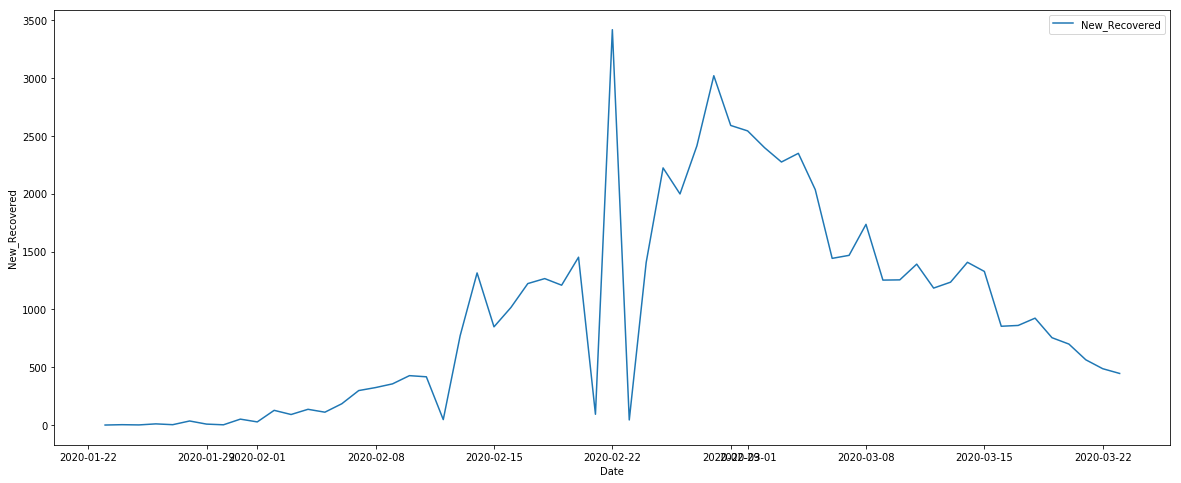

In [23]:
plt.figure(figsize = (20, 8))
sns.lineplot(x="Date", y="New_Recovered", data=df, label='New_Recovered')

As you can see, the newly confirmed, deaths, and recoveries are all volatile. The numbers go up and down like rollercoasters.

Due to the limited technologies and other issues, it is normal that the data is not smooth at the early stages of a virus outbreak.

But this is not ideal for our analysis.

Also, we would like to look at the whole time window of the virus infection. We want to know the time when people had symptoms rather than being confirmed officially.

Hence, we redistribute the number of these features (New_Confirmed, New_Deaths, New_Recovered) for one day equally among a time window before that day.

A confirmed case today might have had symptoms days before. And we are just smoothing out deaths and recoveries as well.

How should we redistribute?

This concept is easier to understand with an example. Assume our data looks like below, with T representing the day and New_Confirmed as the daily confirmed cases.

covid-19 dataset new confirmed example
And we want to set the lookback window to be 5.

We start on day 1 of T = 1.

There is not enough history for the 5-day window to look back. But we can still do a 2-day redistribution.
The 10 cases at T = 1 can be divided into 2 parts, each of 5 cases and add onto T = 0 and T = 1.

covid-19 dataset new confirmed example
Similarly, for day 2 of T = 2, we can redistribute the 10 days among 3 days.

covid-19 dataset new confirmed example
And so on.

Now let’s go back to our analysis.

For the feature New_Confirmed, we set a window size of 10. For New_Deaths and New_Recovered, we set the window to be 3. Since it usually takes longer to confirm a new infection than a death/recovery.

In [24]:
print(df['New_Confirmed'].sum().round())
print(df['New_Deaths'].sum().round())
print(df['New_Recovered'].sum().round())


for i in range(1, len(df.index)):
    new_confirmed = df.iloc[i]['New_Confirmed']
    new_deaths = df.iloc[i]['New_Deaths']
    new_recoveries = df.iloc[i]['New_Recovered']
    
    window_size = min(i, 10)
    new_confirmed_dist = new_confirmed/window_size
    for j in range(window_size-1):
        df.loc[i-j-1, 'New_Confirmed'] += new_confirmed_dist
    df.loc[i, 'New_Confirmed'] = new_confirmed_dist
    
    window_size = min(i, 3)
    new_deaths_dist = new_deaths/window_size
    for j in range(window_size-1):
        df.loc[i-j-1, 'New_Deaths'] += new_deaths_dist
    df.loc[i, 'New_Deaths'] = new_deaths_dist
    
    window_size = min(i, 3)
    new_recoveries_dist = new_recoveries/window_size
    for j in range(window_size-1):
        df.loc[i-j-1, 'New_Recovered'] += new_recoveries_dist
    df.loc[i, 'New_Recovered'] = new_recoveries_dist

print()
print(df['New_Confirmed'].sum().round())
print(df['New_Deaths'].sum().round())
print(df['New_Recovered'].sum().round())

67356.0
3136.0
59851.0

67356.0
3136.0
59851.0


Since we pick the lookback window of 10 days, we remove the latest days that don’t have enough future data.

In [25]:
dte_cutoff = df['Date'].max() - timedelta(days=10)
df = df[df['Date'] <= dte_cutoff]

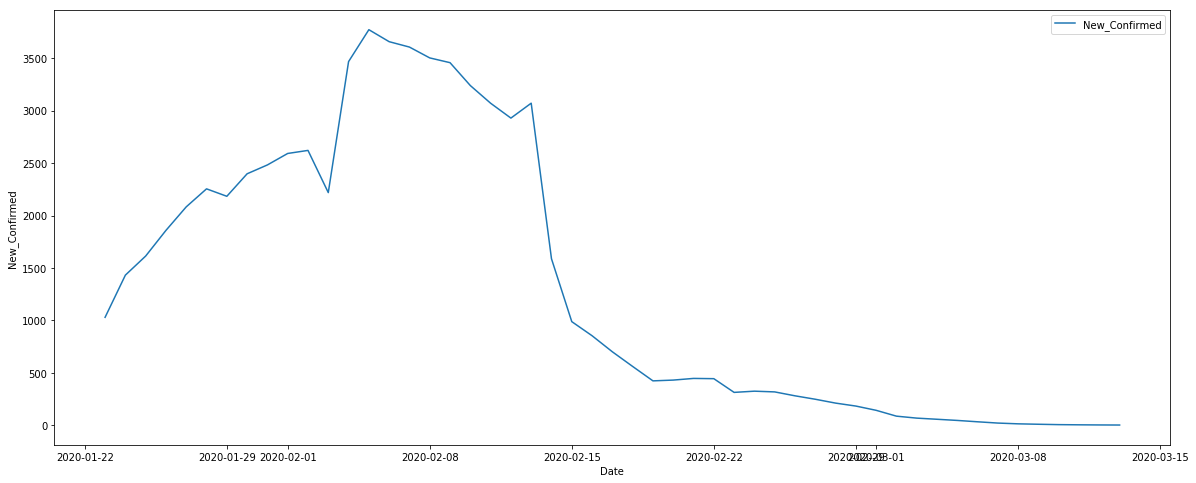

In [26]:
# New confirmed cases after the smoothing process.
plt.figure(figsize = (20, 8))
sns.lineplot(x="Date", y="New_Confirmed", data=df, label='New_Confirmed')

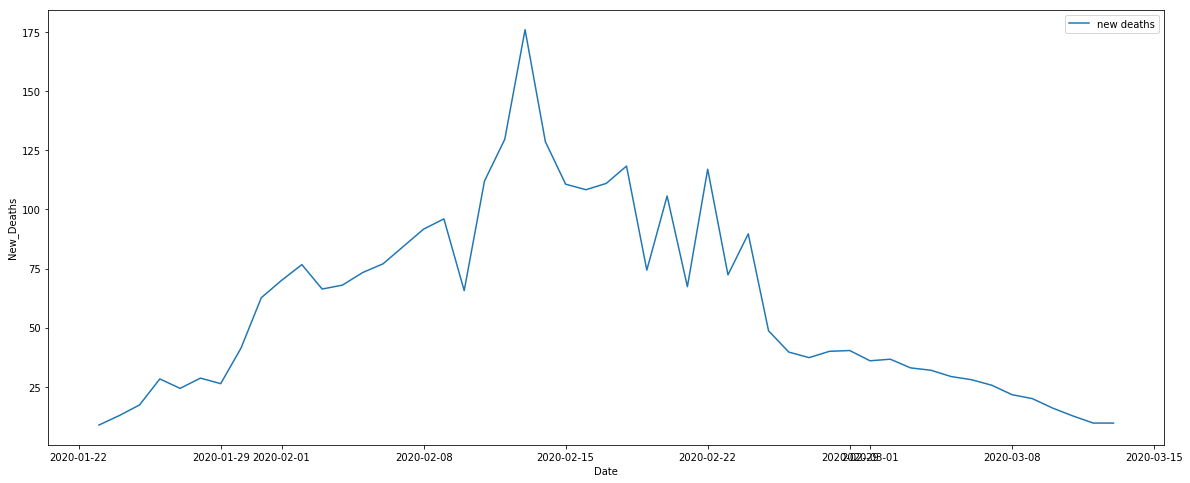

In [27]:
# New deaths after the smoothing process.
plt.figure(figsize = (20, 8))
sns.lineplot(x="Date", y="New_Deaths", data=df, label='new deaths')

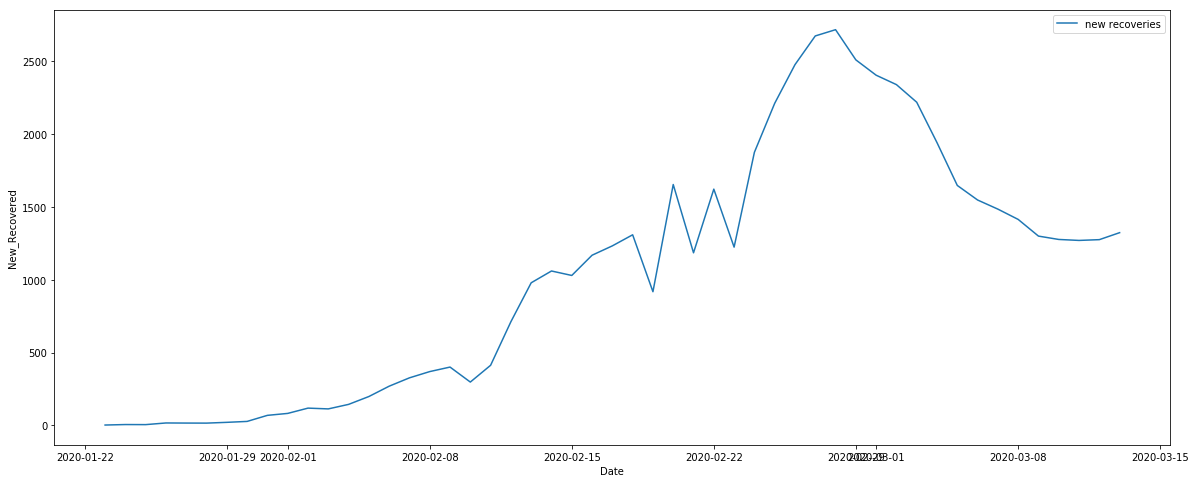

In [28]:
# New recovered after the smoothing process.
plt.figure(figsize = (20, 8))
sns.lineplot(x="Date", y="New_Recovered", data=df, label='new recoveries')

New_Confirmed, New_Deaths, and New_Recovered are all looking much better now.

Before moving on, let’s also remove any nulls from the dataset.

In [29]:
#!pip install hyperopt
import hyperopt
from hyperopt import hp, tpe, STATUS_OK

df = df[df['New_Confirmed'].notnull()]
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,New_Confirmed,New_Deaths,New_Recovered
1,Hubei,China,30.9756,112.2707,2020-01-23,444.0,17.0,28.0,1029.241667,8.833333,1.833333
2,Hubei,China,30.9756,112.2707,2020-01-24,549.0,24.0,31.0,1431.641667,12.833333,5.166667
3,Hubei,China,30.9756,112.2707,2020-01-25,761.0,40.0,32.0,1613.641667,17.333333,4.666667
4,Hubei,China,30.9756,112.2707,2020-01-26,1058.0,52.0,42.0,1858.575000,28.333333,16.000000
5,Hubei,China,30.9756,112.2707,2020-01-27,1423.0,76.0,45.0,2083.025000,24.333333,15.333333


# Choosing the Optimal Model

What is a good statistical model that fits this data?

The Gamma distribution is a popular model for the waiting times between relevant events. It is also known for its flexible shape.



Let’s assume both the time from symptoms to death (time-to-death) and time from symptoms to recovery (time-to-recovery) follow Gamma distributions.

A Gamma distribution has two parameters – a shape parameter and a scale parameter.

So we need to find out the values of these four parameters:

- ttd_scale: time-to-death scale parameter
- ttd_shape: time-to-death shape parameter
- ttr_scale: time-to-recovery scale parameter
- ttr_shape: time-to-recovery shape parameter
And as you may recall, we are trying to estimate the death rate as well. Let’s include it as the last piece of the puzzle to solve.

Now to specify the hyperparameter tuning problem, we will run simulations to:

find a tuple of hyperparameters (ttd_scale, ttd_shape, ttr_scale, ttr_shape, and death_rate) that yields an optimal model (including Gamma distributions) which minimizes a predefined loss function (Mean Squared Error) on given independent data (COVID-19 dataset).

Among the hyperparameter optimization approaches, we will use the random search.

Before deciding, we also experimented with more sophisticated algorithms. But they all focused narrowly on a set of “best” parameters. We want to explore different possible scenarios and use our judgment to see if it makes sense.

So we choose the random search approach, which can provide a wide range of scenarios.

# Running Simulations for Hyperparameter Tuning

For the simulation process, we make the below assumptions based on our judgment:

- ttd_shape, ttr_shape, ttd_scale, ttr_scale are between 0.1 and 100.
- death_rate is between 1% and 30%.

The simulation and optimization function run_sim are coded as below.

In [30]:
def run_sim(ttd_scale, ttd_shape, ttr_scale, ttr_shape, death_rate):
    # run the process.
    dd = {}
    dr = {}
    
    # go through each time in the dataset. The data is sorted by date, so the first row is the earliest date and the last row is the latest. 
    for i in range(len(df.index)):
        new_cases = df.iloc[i]['New_Confirmed']
        date = df.iloc[i]['Date']
        
        # We have the new cases for the day. Use the death rate parameter to determine which of them will die and which will recover from the
        # infection.
        deaths = int((new_cases*death_rate).round())
        
        # Of the people that will die, how long will it take them to die. Use the gamma distribution to determine this.
        time_to_death = np.random.gamma(ttd_shape, ttd_scale, deaths).round()
        
        # Of the people that will recover, how long will it take them to recover. Use the gamma distribution.
        recoveries = int(new_cases - deaths)
        time_to_recovery = np.random.gamma(ttr_shape, ttr_scale, recoveries).round()
        
        # find the date they will die (Use the datetime functions in our article.)
        for ttd in time_to_death:
            date_of_death = date + timedelta(days=ttd) # this gives the date they will die.
            
            # this keeps track of how many will die on which dates.
            if date_of_death in dd:
                dd[date_of_death] += 1
            else:
                dd[date_of_death] = 1
                
        # find the date they will recover. Same as the previous loop but for recoveries.
        for ttr in time_to_recovery:
            date_of_recovery = date + timedelta(days=ttr)
            if date_of_recovery in dr:
                dr[date_of_recovery] += 1
            else:
                dr[date_of_recovery] = 1

    # Compile the dates of death and recoveries that were predicted in the above process into dataframes.
    df_dpred = pd.DataFrame(list(dd.items()), columns=['Date', 'pred_new_deaths'])
    df_rpred = pd.DataFrame(list(dr.items()), columns=['Date', 'pred_new_recoveries'])
    
    # Join the predicted deaths/recoveries to the actual data.
    df_res = pd.merge(df, df_dpred, on='Date', how='left')
    df_res = pd.merge(df_res, df_rpred, on='Date', how='left')
    df_res = df_res.fillna(0)
    
    # calculate the loss (mean square error on the log of deaths minus log of predicted deaths) + the same for recoveries.
    # The smaller this loss is, the better the simulation fits the actual data.
    loss = mean_squared_error(np.log(df_res['New_Deaths']+0.1), np.log(df_res['pred_new_deaths'] + 0.1))
    loss += mean_squared_error(np.log(df_res['New_Recovered'] + 0.1), np.log(df_res['pred_new_recoveries'] + 0.1))
    
    # Loss must be minimized
    return df_res, loss

Then this function run_sim is simulated for 20,000 times. The result of each simulation is saved in the test.txt file.

Within the procedure, we use the hyperopt package to apply the hyperparameter optimization techniques.

If you are interested in learning more about the package, please read Automated Machine Learning Hyperparameter Tuning in Python.

There are also other packages available for hyperparameter optimization. But we choose hyperopt for its popularity. Stay tuned for our future articles with more options!

Update: take a look at this article for a better package Hyperparameter Tuning with Python: Complete Step-by-Step Guide.

In [33]:
from hyperopt import Trials, fmin
import csv

space = {
    'ttd_shape': hp.uniform('ttd_shape', 0.1, 100.0),
    'ttd_scale': hp.uniform('ttd_scale', 0.1, 100.0),
    'ttr_shape': hp.uniform('ttr_shape', 0.1, 100.0),
    'ttr_scale': hp.uniform('ttr_scale', 0.1, 100.0),
    'death_rate': hp.uniform('death_rate', 0.01, 0.3)
}

# Keep track of results
trials = Trials()

ITERATION = 0

# the objective function runs the simulation and outputs a loss score (from the simulation: mean squared error).
# this will be called thousands of times by the optimizer.
def objective(params, n_folds = 5):

    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    ttd_scale = params['ttd_scale']
    ttd_shape = params['ttd_shape']
    ttr_scale = params['ttr_scale']
    ttr_shape = params['ttr_shape']
    death_rate = params['death_rate']
    
    _, loss = run_sim(ttd_scale, ttd_shape, ttr_scale, ttr_shape, death_rate)
    
    # save the results in a csv file: text.csv.
    #with open('D:\\data\\test.csv', 'a') as f:
    with open('test.txt', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([ITERATION, loss, ttd_scale, ttd_shape, ttr_scale, ttr_shape, death_rate])
    
    ret = {'loss': loss, 'params': params, 'status': STATUS_OK}
    
    # Dictionary with information for evaluation
    return ret


# Run optimization
# tpe.rand.suggest - Random search.
# tpe.suggest - Tree Parzen search (more advanced)
#
# We choose to do random search because we want to see a wide range of scenarios. The tree parzen
# tries to find the best set of parameters and focuses the search around that area. It does a better
# job of finding the best set of parameters, but we don't see other scenarios like we do with random
# search. For most ML projects we just care about the set of parameters that result in the lowest loss
# but here we want to see more possibilities.
#

# remove the file if it exists.
import os
if os.path.exists("D:\\data\\test.txt"):
    os.remove("D:\\data\\test.txt")
else:
    print("The file does not exist")

# Run the simulations a lot of times. Each time the results will be recorded in test.csv file.
best = fmin(fn = objective,
            space = space,
            algo = tpe.rand.suggest,
            max_evals = 10, 
            #max_evals = 20000, 
            trials = trials)

The file does not exist
100%|██████████| 5/5 [00:04<00:00,  1.17trial/s, best loss: 49.59331458713453]


Next, leave your computer to “struggle” for ~2 hours to run the entire simulation!

Let’s take a look at the simulation results.

In [34]:
# Look at the results from test.txt. Sort by the trials with the lowest loss.
results = pd.read_csv('test.txt', names=['iteration', 'loss', 'ttd_scale', 'ttd_shape', 'ttr_scale', 'ttr_shape', 'death_rate'])
results.nsmallest(20, columns='loss')

,iteration,loss,ttd_scale,ttd_shape,ttr_scale,ttr_shape,death_rate
19,20,73.849719,48.772336,0.236867,85.896784,22.347443,0.063192
11,12,79.529463,2.557733,7.397888,48.223321,72.074392,0.223647
0,1,95.743694,4.702413,13.920144,18.259883,38.364800,0.280266
6,7,103.096470,16.221485,86.538718,51.888398,5.604840,0.242267
17,18,111.013984,39.955049,6.638807,27.467417,85.961526,0.204419
1,2,111.829247,60.745770,47.872582,62.406392,26.589121,0.209114
2,3,111.829247,99.033824,85.044872,96.112509,14.473727,0.165615
3,4,111.829247,72.152322,67.846484,77.085896,24.714104,0.252390
4,5,111.829247,93.162813,91.375427,85.655064,87.609041,0.121809
5,6,111.829247,79.930215,42.752101,93.609598,72.608618,0.011278


Let’s examine both of the best two scenarios.

Both of them claim that the death rate is much higher at 22% and 9%!

# Visualizing the Results

Scenario One: Death rate = 22%
- Death
Under this doomsday scenario, the death rate is as high as 22%.

While the prediction seemed to match the actual at earlier days, they diverged since early February.

So good news, the death rate is not as high as this scenario suggests.

- Recovery
The predicted recovery was higher than the actual at the beginning while they moved closer at later days.

In [39]:
# pick a set of parameters that resulted in a low loss.
ttd_scale = 63.696418
ttd_shape = 0.968338
ttr_scale = 15.034069
ttr_shape = 1.851922
death_rate = 0.218912

# run the simulation with the parameters.
df_res, loss = run_sim(ttd_scale=ttd_scale, 
                       ttd_shape=ttd_shape, 
                       ttr_scale=ttr_scale, 
                       ttr_shape=ttr_shape, 
                       death_rate=death_rate)
loss



1.891769117054705

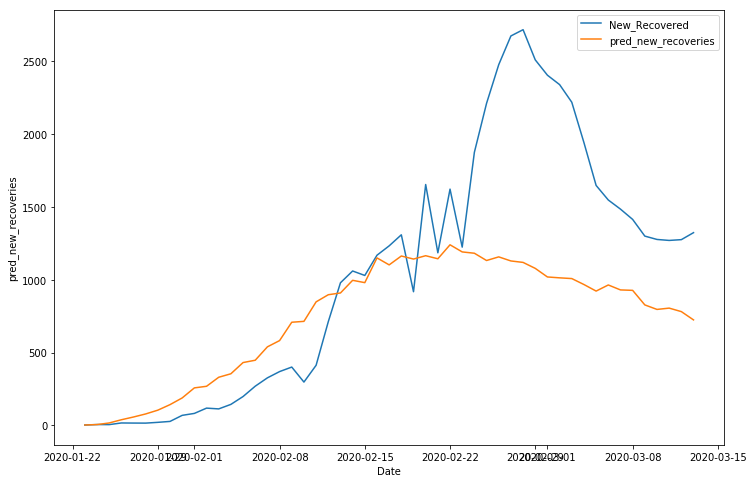

In [40]:
# visualize how well it fits recoveries.
sns.lineplot(x="Date", y="New_Recovered",       data=df_res, label='New_Recovered')
sns.lineplot(x="Date", y="pred_new_recoveries", data=df_res, label='pred_new_recoveries')

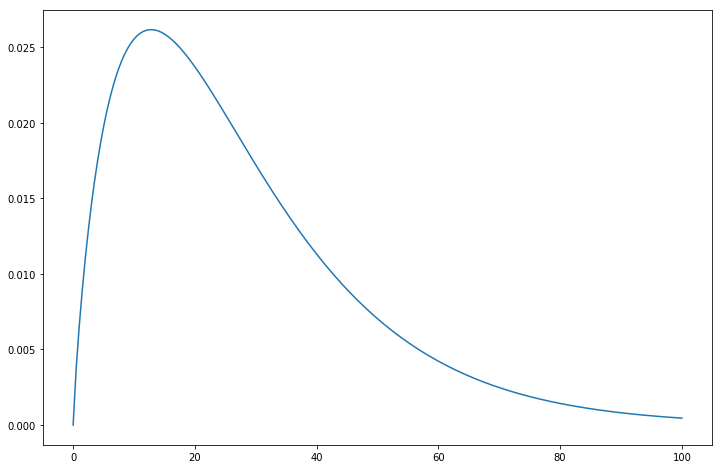

In [41]:
import scipy.stats as stats

# look at the shape of the time to recovery distribution.
x = np.linspace (0, 100, 200)
y = stats.gamma.pdf(x, a=ttr_shape, scale=ttr_scale) 

sns.lineplot(x=x, y=y)

Scenario Two: Death rate = 8.7%
- Death
Even though this scenario gave a higher loss function, the predicted number of death match the actual death closer throughout the time.

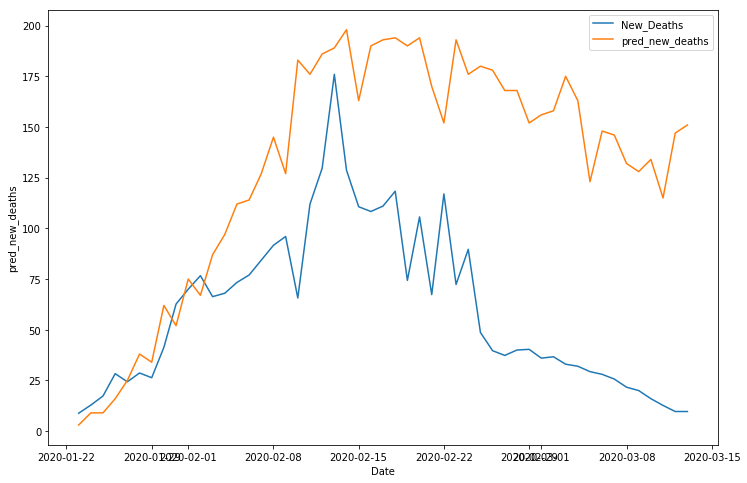

In [42]:
# visualize how well it fits deaths.
sns.lineplot(x="Date", y="New_Deaths",      data=df_res, label='New_Deaths')
sns.lineplot(x="Date", y="pred_new_deaths", data=df_res, label='pred_new_deaths')

- Recovery
Under this scenario, the predicted recoveries also match closer to the actual numbers throughout time.

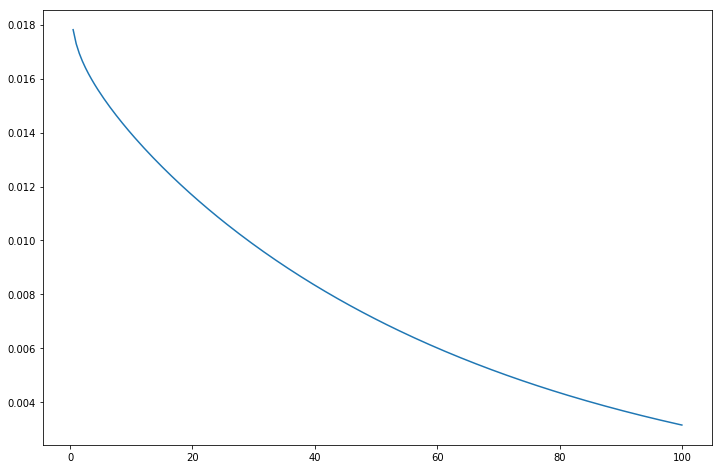

In [43]:
import scipy.stats as stats

# look at the shape of the time to recovery distribution.
x = np.linspace (0, 100, 200)
y = stats.gamma.pdf(x, a=ttd_shape, scale=ttd_scale) 

sns.lineplot(x=x, y=y)

So given the above observations, the second scenario is more likely to be real, even for the severe Hubei province.

Please note that the analysis and conclusions are all based on certain assumptions. And we were only trying to tune the death rate up, as mentioned in Step #3.

The only sure thing is that we all hope the coronavirus crisis passes on soon!

Stay strong and healthy.

Source:

https://www.justintodata.com/coronavirus-death-rate-with-hyperparameter-tuning/

https://gist.github.com/liannewriting/ab23ea2f38364e9c19f08ba07ffa8c37

https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a

https://www.justintodata.com/hyperparameter-tuning-with-python-complete-step-by-step-guide/